In [1]:
from __future__ import print_function
%matplotlib inline

from sklearn import cluster
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cv2
import numpy as np
import math

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

In [65]:
def circle_fit(x_coords,y_coords,pixel_len):
    # Pre-processing for Circle Fitting Algorithm for Histological objects
    x1 = np.array(x_coords) # Array of x-coordinates 
    y1 = np.array(y_coords) # Array of y-coordinates

    # Apply transformation on x,y co-ordinates
    x2 = x1.reshape(1, pixel_len)
    y2 = y1.reshape(1, pixel_len)

    # Mean value of x co-ordinates
    sum_x=0
    for i in range(pixel_len):
        sum_x=sum_x+x2[0,i]
    x_mean=sum_x/(pixel_len -1)

    # Mean value of y co-ordinates
    sum_y=0
    for i in range(pixel_len):
        sum_y=sum_y+y2[0,i]
    y_mean=sum_y/(pixel_len - 1)
    
    # Circle Fitting Algorithm using linear algebra    
    u=[]
    v=[]
    Suv  = 0
    Suu  = 0
    Svv  = 0
    Suuv = 0
    Suvv = 0
    Suuu = 0
    Svvv = 0

    # calculation of the reduced coordinates
    for i in range(pixel_len):
            u.append((x2[0,i] - x_mean))
            v.append((y2[0,i] - y_mean))

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    for i in range(pixel_len):
        Suv  = Suv + (u[i]*v[i])
        Suu  = Suu+(u[i]*u[i])
        Svv  = Svv+(v[i]*v[i])
        Suuv = Suuv+(u[i]*u[i]*v[i])
        Suvv = Suvv+(u[i]* v[i]**2)
        Suuu = Suuu+(u[i]**3)
        Svvv = Svvv+(v[i]**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc_1 = x_mean + uc
    yc_1 = y_mean + vc

    # Calcuating Radius
    alpha = uc**2 + vc**2 +((Suu+Svv)/(pixel_len - 1))
    radius=math.sqrt(alpha)
    
    return xc_1, yc_1,radius 

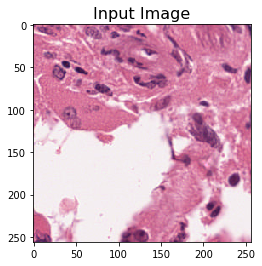

In [2]:
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

In [3]:
# Converting 3D image data into 2D data for k-means clustering
x, y, z = imInput.shape
image_2d = imInput.reshape(x*y, z)
image_2d.shape

(65536, 3)

In [5]:
# Applying K-means clusters on the given image
kmeans_cluster = cluster.KMeans(n_clusters=3)
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

In [6]:
cluster_labels.shape

(65536,)

In [7]:
# Each row represents respective cluster# 
# Each column in each row represents color intensity (RGB)
# For Eg, in this case, 3 clusters with their RGB values
# Cluster#0 is clustered with (243.01990705, 229.31279562, 233.74852959)
cluster_centers

array([[243.01990705, 229.31279562, 233.74852959],
       [211.21876855, 127.25825318, 163.44356371],
       [142.47274174,  71.00358138, 121.60684441]])

In [8]:
cluster_labels

array([2, 2, 1, ..., 1, 1, 1], dtype=int32)

In [10]:
cluster_labels1=np.zeros((256,256))

In [11]:
cluster_labels1= cluster_labels.reshape(256, 256)

In [12]:
cluster_labels1.shape

(256, 256)

In [13]:
imOutput=cluster_centers[cluster_labels].reshape(x, y, z)

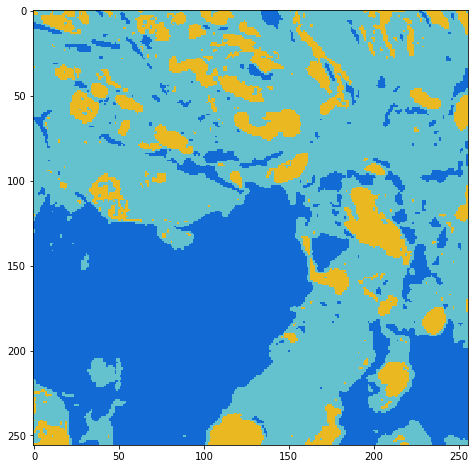

In [14]:
plt.figure(figsize = (15,8))
plt.imshow((imOutput * 255).astype(np.uint8))

In [15]:
imOutput.shape, imInput.shape

((256, 256, 3), (256, 256, 3))

In [16]:
imOutput.size

196608

In [17]:
# Adding up three cluster_positions with their x,y coordinates
clust0_x=[]
clust0_y=[]
clust1_x=[]
clust1_y=[]
clust2_x=[]
clust2_y=[]
for i in range(0,255):
       for j in range(0,255):
        if (cluster_labels1[i,j] == 0): clust0_x.append([i]),clust0_y.append([j])
        if (cluster_labels1[i,j] == 1): clust1_x.append([i]),clust1_y.append([j])
        if (cluster_labels1[i,j] == 2): clust2_x.append([i]),clust2_y.append([j])
z=len(clust0_x)+len(clust1_x)+len(clust2_x)
z

65025

In [18]:
len(clust0_x),len(clust1_x),len(clust2_x)

(24134, 33480, 7411)

In [19]:
# Identifying image positions/pixels matching nearest cluster0 intenstity values 
cluster_0_points = np.where(imInput ==(243, 229, 233)) #[243.01990705, 229.31279562, 233.74852959] Cluster#0 values

In [31]:
np.shape(cluster_0_points)

(3, 3442)

In [20]:
# First Row represents, x-coordinates of position, Second row represents y-coordinates
# Third row represents respective cluster Number
# For Eg, the first columun value (0,136,0) represents, (0,136) position in the image with cluster#0
cluster_0_points

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([136, 138, 141, ..., 187, 198, 236]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [21]:
# Cluster#0 intensity values [243.01990705, 229.31279562, 233.74852959]
# cluster_0, cluster_0, cluster_1, cluster_0
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,136], imInput[0,138], imInput[255,198], imInput[255,236] 

(Array([243, 220, 226], dtype=uint8),
 Array([243, 223, 224], dtype=uint8),
 Array([247, 229, 227], dtype=uint8),
 Array([243, 186, 205], dtype=uint8))

In [22]:
# Identifying image positions/pixels matching nearest cluster1 intenstity values 
cluster_1_points = np.where(imInput ==(211, 127, 163)) #[211.21876855, 127.25825318, 163.44356371] Cluster#1 values

In [23]:
cluster_1_points

(array([  0,   0,   0, ..., 254, 255, 255]),
 array([ 33,  56,  60, ..., 226, 223, 226]),
 array([0, 1, 1, ..., 2, 0, 2]))

In [24]:
# Cluster#1 intensity values [211.21876855, 127.25825318, 163.44356371]
# cluster_0, cluster_1, cluster_2
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,33], imInput[0,56], imInput[255,226] 

(Array([211, 129, 167], dtype=uint8),
 Array([208, 127, 183], dtype=uint8),
 Array([218, 119, 163], dtype=uint8))

In [25]:
# Identifying image positions/pixels matching nearest cluster2 intenstity values 
cluster_2_points = np.where(imInput ==(142, 71, 121)) #[142.47274174,  71.00358138, 121.60684441] Cluster#2 values

In [26]:
cluster_2_points

(array([  0,   0,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   3,
          3,   3,   3,   3,   3,   4,   4,   4,   4,   4,   4,   4,   5,
          5,   5,   5,   5,   6,   7,   7,   7,   7,   7,   8,   9,   9,
          9,   9,  10,  10,  12,  12,  12,  12,  14,  14,  14,  14,  14,
         14,  14,  14,  15,  15,  17,  18,  18,  18,  18,  20,  23,  23,
         23,  25,  25,  26,  26,  29,  31,  31,  32,  32,  33,  33,  33,
         33,  34,  34,  34,  34,  34,  34,  34,  35,  35,  35,  35,  35,
         36,  36,  36,  36,  36,  37,  38,  38,  38,  39,  39,  39,  39,
         39,  40,  41,  41,  41,  41,  42,  42,  43,  43,  43,  44,  45,
         45,  46,  46,  47,  48,  48,  49,  50,  50,  51,  52,  52,  53,
         53,  53,  53,  54,  55,  55,  55,  56,  56,  56,  56,  57,  57,
         57,  57,  57,  58,  59,  59,  59,  60,  61,  61,  61,  61,  61,
         61,  61,  62,  62,  63,  63,  63,  64,  64,  64,  66,  66,  66,
         67,  67,  68,  68,  68,  68,  68,  68,  69

In [27]:
# Cluster#1 intensity values [142.47274174,  71.00358138, 121.60684441]
# cluster_0, , cluster_1, cluster_2
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,19],imInput[1,0], imInput[0,204]

(Array([142,  69, 122], dtype=uint8),
 Array([128,  71, 124], dtype=uint8),
 Array([162,  76, 121], dtype=uint8))

In [49]:
print(np.shape(cluster_0_points))
print(np.shape(cluster_1_points))
print(np.shape(cluster_2_points))

(3, 3442)
(3, 2326)
(3, 377)


In [53]:
cluster_0_points[0].shape, cluster_1_points[0].shape, cluster_2_points[0].shape

((3442,), (2326,), (377,))

In [64]:
#Splitting up image positios/pixels of cluster_0_points into another 3 clusters based on clusteral values 
cluster_0_0x=[]
cluster_0_1x=[]
cluster_0_2x=[]
cluster_0_0y=[]
cluster_0_1y=[]
cluster_0_2y=[]
for i in range(0,3442):
        if (cluster_0_points[2][i] == 0): cluster_0_0x.append(cluster_0_points[0][i]), cluster_0_0y.append(cluster_0_points[1][i])
        if (cluster_0_points[2][i] == 1): cluster_0_1x.append(cluster_0_points[0][i]), cluster_0_1y.append(cluster_0_points[1][i])
        if (cluster_0_points[2][i] == 2): cluster_0_2x.append(cluster_0_points[0][i]), cluster_0_2y.append(cluster_0_points[1][i])  

In [61]:
#Splitting up image positios/pixels of cluster_1_points into another 3 clusters based on clusteral values 
cluster_1_0x=[]
cluster_1_1x=[]
cluster_1_2x=[]
cluster_1_0y=[]
cluster_1_1y=[]
cluster_1_2y=[]
for i in range(0,2326):
        if (cluster_1_points[2][i] == 0): cluster_1_0x.append(cluster_1_points[0][i]), cluster_1_0y.append(cluster_1_points[1][i])
        if (cluster_1_points[2][i] == 1): cluster_1_1x.append(cluster_1_points[0][i]), cluster_1_1y.append(cluster_1_points[1][i])
        if (cluster_1_points[2][i] == 2): cluster_1_2x.append(cluster_1_points[0][i]), cluster_1_2y.append(cluster_1_points[1][i])  

In [63]:
#Splitting up image positios/pixels of cluster_2_points into another 3 clusters based on clusteral values 
cluster_2_0x=[]
cluster_2_1x=[]
cluster_2_2x=[]
cluster_2_0y=[]
cluster_2_1y=[]
cluster_2_2y=[]
for i in range(0,377):
        if (cluster_2_points[2][i] == 0): cluster_2_0x.append(cluster_2_points[0][i]), cluster_2_0y.append(cluster_2_points[1][i])
        if (cluster_2_points[2][i] == 1): cluster_2_1x.append(cluster_2_points[0][i]), cluster_2_1y.append(cluster_2_points[1][i])
        if (cluster_2_points[2][i] == 2): cluster_2_2x.append(cluster_2_points[0][i]), cluster_2_2y.append(cluster_2_points[1][i])  

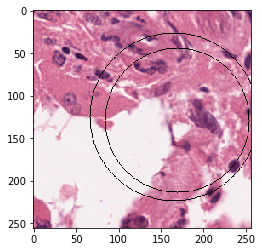

In [79]:
plt.imshow(imInput)

### start

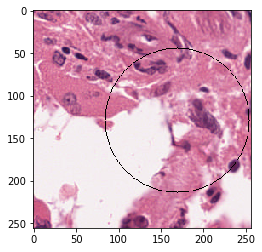

In [92]:
# Cluster_0_0 Circle (Largest Object Circle) generation
cluste_0_0_len=len(cluster_0_0x)
cluster_0_0_x, cluster_0_0_y, cluster_0_0_radius = circle_fit(cluster_0_0x, cluster_0_0y, cluste_0_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_0_x)),int(round(cluster_0_0_y))),int(round(cluster_0_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

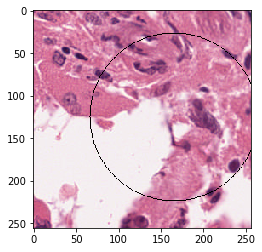

In [94]:
# Cluster_0_1 Circle (Largest Object Circle) generation
cluste_0_1_len=len(cluster_0_1x)
cluster_0_1_x, cluster_0_1_y, cluster_0_1_radius = circle_fit(cluster_0_1x, cluster_0_1y, cluste_0_1_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_1_x)),int(round(cluster_0_1_y))),int(round(cluster_0_1_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))           

im = cv2.imread('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

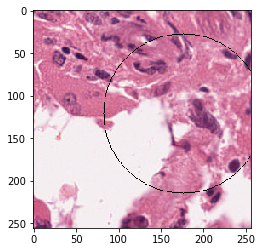

In [95]:
# Cluster_0_2 Circle (Largest Object Circle) generation
cluste_0_2_len=len(cluster_0_2x)
cluster_0_2_x, cluster_0_2_y, cluster_0_2_radius = circle_fit(cluster_0_2x, cluster_0_2y, cluste_0_2_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_2_x)),int(round(cluster_0_2_y))),int(round(cluster_0_2_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))           

im = cv2.imread('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

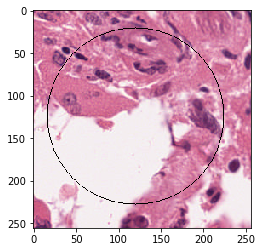

In [97]:
# Cluster_1_0 Circle (Largest Object Circle) generation
cluste_1_0_len=len(cluster_1_0x)
cluster_1_0_x, cluster_1_0_y, cluster_1_0_radius = circle_fit(cluster_1_0x, cluster_1_0y, cluste_1_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_1_0_x)),int(round(cluster_1_0_y))),int(round(cluster_1_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()